In [1]:
from methods.EX import EX

In [2]:
# Example input tensor with 6 channels and sequence length of 256
import torch
from methods import UNet
class args:
    def __init__(self):
        self.in_channels = 6
        self.out_channels = 1
        self.embed_dim = 256
        self.num_heads = 8
        

input_tensor = torch.randn(256, 200, 6)  # Batch size 1, 6 channels, 256 time steps

# Instantiate the model
model = EX(args())

# Forward pass
output = model(input_tensor)

print(output.shape)  # Should output: torch.Size([1, 1, 256])

# trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) 


torch.Size([256, 200, 1])
3445569


In [3]:


unet = UNet(args())
output = unet(input_tensor)
print(output.shape)  # Should output: torch.Size([1, 1, 256])

torch.Size([256, 200, 1])


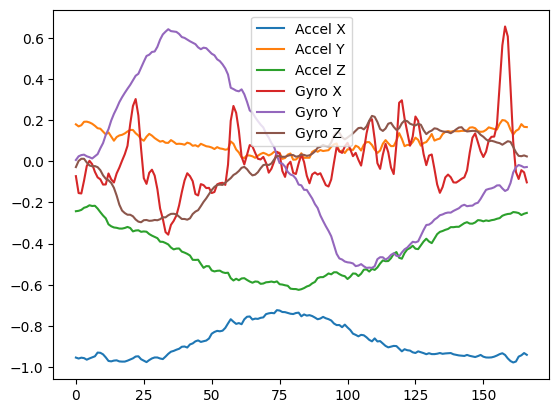

[[-0.93327338  0.20072937 -0.26473984  0.56399256 -0.13178733  0.08069828]
 [-0.94151312  0.19830322 -0.25947553  0.65573347 -0.14424312  0.08926211]
 [-0.95848089  0.18696594 -0.25605758  0.60710549 -0.13703395  0.0978655 ]
 [-0.97132879  0.15393066 -0.25477584  0.36014274 -0.10572724  0.09437495]
 [-0.97819531  0.13037111 -0.24678022  0.09451427 -0.05386328  0.07004798]
 [-0.97352612  0.14807132 -0.24829082 -0.05176611 -0.02881283  0.0438836 ]
 [-0.94970715  0.1559601  -0.25146466 -0.08592528 -0.01780233  0.02650013]
 [-0.9432984   0.18083191 -0.26115397 -0.04318128 -0.02240986  0.02493606]
 [-0.93234277  0.16748051 -0.25474535 -0.05360682 -0.02949313  0.028748  ]
 [-0.94100958  0.16653442 -0.25085431 -0.10234114 -0.02768087  0.02378003]]


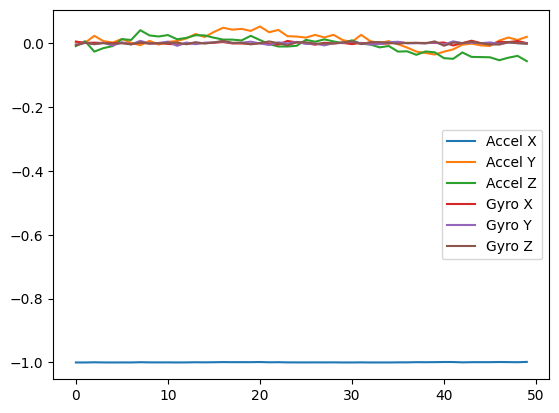

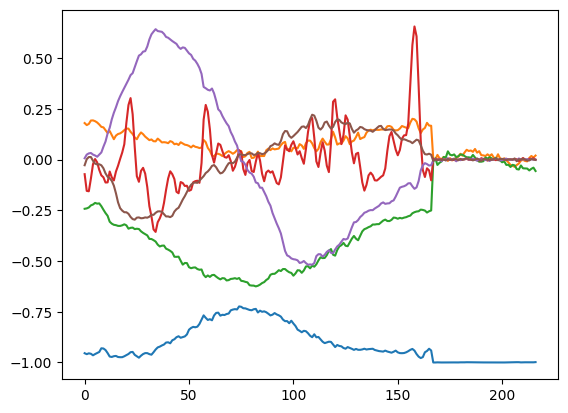

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_imu_noise_with_quaternion(
    initial_orientation, 
    gravity_vector_g=np.array([0, 0, 1.0]),  # Default gravity in g-units along Z-axis
    max_length=20, 
    noise_type="static_pause",
    accel_intensity=0.02,
    gyro_intensity=0.05,
    fluctuation_level=0.01
):
    """
    Generate IMU noise (accelerometer and gyroscope) with slight fluctuations using quaternion dynamics.
    
    Parameters:
        initial_orientation (array): Initial quaternion orientation.
        gravity_vector_g (array): Gravity vector in g-units, defaulting to 1g along the Z-axis.
        max_length (int): Length of the generated noise segment.
        noise_type (str): Type of movement to simulate ("static_pause" or "sudden_change").
        accel_intensity (float): Intensity for accelerometer noise.
        gyro_intensity (float): Intensity for gyroscope noise.
        fluctuation_level (float): Amount of fluctuation to add to simulate natural variation.
        
    Returns:
        array: Combined accelerometer and gyroscope noise segment.
    """
    # Set noise intensities based on movement type
    if noise_type == "static_pause":
        accel_intensity = 0.02  # Small, gentle motion
        gyro_intensity = 0.01
    elif noise_type == "sudden_change":
        accel_intensity = 0.5  # Higher intensity for sudden changes
        gyro_intensity = 0.3
    else:
        raise ValueError("Unknown noise_type. Choose 'static_pause' or 'sudden_change'.")

    # Initialize variables to store accelerometer and gyroscope data
    accel_data = []
    gyro_data = []
    current_orientation = initial_orientation

    for _ in range(max_length):
        # Introduce small fluctuations to the gravity vector
        fluctuation = np.random.uniform(-fluctuation_level, fluctuation_level, 3)
        fluctuated_gravity = gravity_vector_g + fluctuation
        fluctuated_gravity /= np.linalg.norm(fluctuated_gravity)  # Normalize to maintain "g" units

        # Generate random axis and angle for quaternion rotation to simulate orientation fluctuations
        random_axis = np.random.uniform(-1, 1, 3)
        random_axis /= np.linalg.norm(random_axis)  # Normalize the axis
        random_accel_angle = np.random.uniform(-accel_intensity, accel_intensity)
        random_gyro_angle = np.random.uniform(-gyro_intensity, gyro_intensity)

        # Create quaternion rotations for accelerometer and gyroscope
        accel_rotation_quat = R.from_rotvec(random_accel_angle * random_axis).as_quat()
        gyro_rotation_quat = R.from_rotvec(random_gyro_angle * random_axis).as_quat()

        # Update the orientation for accelerometer and rotate fluctuated gravity vector
        accel_orientation = R.from_quat(current_orientation) * R.from_quat(accel_rotation_quat)
        rotated_gravity = accel_orientation.apply(fluctuated_gravity)
        accel_data.append(rotated_gravity)

        # Update the orientation for gyroscope and calculate angular velocity
        gyro_orientation = R.from_quat(current_orientation) * R.from_quat(gyro_rotation_quat)
        delta_rotation = gyro_orientation * R.from_quat(current_orientation).inv()
        angular_velocity = delta_rotation.as_rotvec()  # Simulate gyroscope output

        gyro_data.append(angular_velocity)
        current_orientation = accel_orientation.as_quat()  # Update orientation

    # Convert accelerometer and gyroscope lists to arrays and combine
    accel_data = np.array(accel_data)
    gyro_data = np.array(gyro_data)
    imu_noise_segment = np.hstack([accel_data, gyro_data])

    return imu_noise_segment



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
noise = pd.read_csv('data/physiq/segment_sessions_one_repetition_data_E1/S1_E1_R_30_0_0.csv').to_numpy()[:, 1:7]
# noise_shape =
plt.plot(noise, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
plt.legend()
plt.show()

print(noise[-10::, :])
data = noise[-10::, :]

# Extract accelerometer (first three columns) and gyroscope (last three columns)
accel_data = data[:, 0:3]
gyro_data = data[:, 3:6]

# Calculate the initial gravity vector and orientation in "g" units
gravity_vector_g = accel_data.mean(axis=0)  # Mean accelerometer data as gravity vector in "g" units
gravity_vector_g /= np.linalg.norm(gravity_vector_g)  # Normalize to 1g

# Use the gravity vector to define initial orientation quaternion
# Assume gravity aligns along the Z-axis in the world frame (default initial orientation)
initial_orientation = R.from_rotvec(np.cross([1, 0, 0], gravity_vector_g)).as_quat()

# Now, pass this orientation and gravity vector to the noise generation function
imu_noise_segment = generate_imu_noise_with_quaternion(
    initial_orientation=initial_orientation,
    gravity_vector_g=gravity_vector_g,
    max_length=50,
    noise_type="static_pause"
)

# print("IMU Noise Segment:\n", imu_noise_segment)

plt.plot(imu_noise_segment, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
plt.legend()
plt.show()

# concatenate the noise with the original data
noisy_data = np.vstack([noise, imu_noise_segment])
plt.plot(noisy_data, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
# plt.legend()
plt.show()


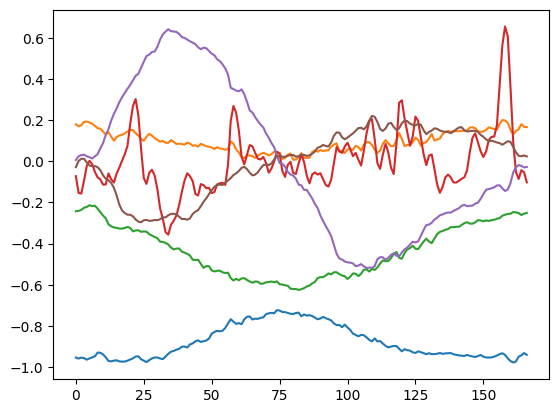

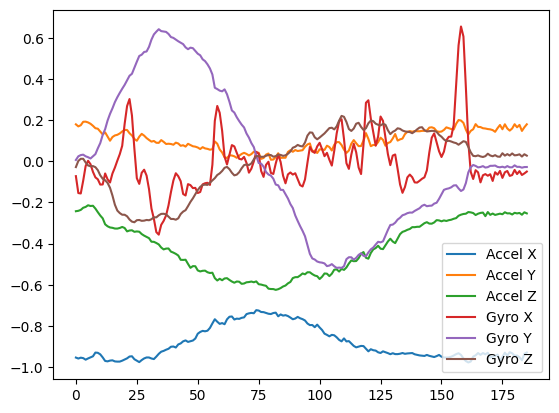

In [128]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_patterned_imu_noise(
    data,
    reference_length=5,
    max_length=25,
    noise_type="static_pause",
    range_percentage=0.05,
    peak_intensity=1.0,
    peak_probability=0.1,
    directional_bias=0.1,
):
    # Separate accelerometer and gyroscope data from the initial pattern
    accel_baseline = data[-reference_length:, 0:3]
    gyro_baseline = data[-reference_length:, 3:6]

    # Calculate the mean and range for static pause fluctuation level
    accel_mean = accel_baseline.mean(axis=0)
    gyro_mean = gyro_baseline.mean(axis=0)
    accel_range = accel_baseline.max(axis=0) - accel_baseline.min(axis=0)
    gyro_range = gyro_baseline.max(axis=0) - gyro_baseline.min(axis=0)

    # Set fluctuation level based on a percentage of the range
    fluctuation_level_accel = range_percentage * accel_range
    fluctuation_level_gyro = range_percentage * gyro_range

    # Number of time steps in the noise segment
    T = np.random.randint(max_length // 5, max_length)

    # Generate directional trend
    directional_trend = (
        directional_bias * np.linspace(0, 1, T).reshape(-1, 1)
        * np.random.choice([-1, 1], size=(1, 3))
    )

    # Generate random fluctuations for accelerometer and gyroscope for each time step
    accel_fluctuations = np.random.uniform(
        -fluctuation_level_accel, fluctuation_level_accel, (T, 3)
    )
    gyro_fluctuations = np.random.uniform(
        -fluctuation_level_gyro, fluctuation_level_gyro, (T, 3)
    )

    # Determine peak indices for accelerometer and gyroscope randomly
    peak_indices = np.random.rand(T) < peak_probability
    peak_accel = np.random.uniform(-peak_intensity, peak_intensity, (T, 3))
    peak_gyro = np.random.uniform(-peak_intensity, peak_intensity, (T, 3))

    # Apply peak intensity only at selected indices
    accel_fluctuations[peak_indices] = peak_accel[peak_indices]
    gyro_fluctuations[peak_indices] = peak_gyro[peak_indices]

    # Combine trend and fluctuation based on noise type
    if noise_type == "directional_shift":
        accel_samples = accel_mean + directional_trend + accel_fluctuations
        gyro_samples = gyro_mean + directional_trend + gyro_fluctuations
    else:
        accel_samples = accel_mean + accel_fluctuations
        gyro_samples = gyro_mean + gyro_fluctuations

    # Generate random rotation vectors and apply them to the accelerometer data
    random_axes = np.random.uniform(-1, 1, (T, 3))
    random_axes /= np.linalg.norm(random_axes, axis=1).reshape(-1, 1)
    rotation_angles = np.random.uniform(
        -fluctuation_level_accel.mean(), fluctuation_level_accel.mean(), T
    )
    rotation_vectors = random_axes * rotation_angles.reshape(-1, 1)
    rotations = R.from_rotvec(rotation_vectors)
    rotated_accel = rotations.apply(accel_samples)

    # Stack accelerometer and gyroscope data to form the IMU noise segment
    imu_noise_segment = np.hstack([rotated_accel, gyro_samples])

    return imu_noise_segment



# Provided initial data
# initial_data = noise[-5::, :]

# Generate noise that follows the initial data pattern
imu_noise_segment = generate_patterned_imu_noise(
    noise,
    noise_type="static_pause",
    range_percentage=0.5, # rest position
    # fluctuation_multiplier=0.05,
    # fluctuation_level=0.01,
    # peak_intensity=0.01,
    peak_probability=0
)
plt.plot(noise, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
plt.show()
# concatenate the noise with the original data
noisy_data = np.vstack([noise, imu_noise_segment])
plt.plot(noisy_data, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
plt.legend()
plt.show()




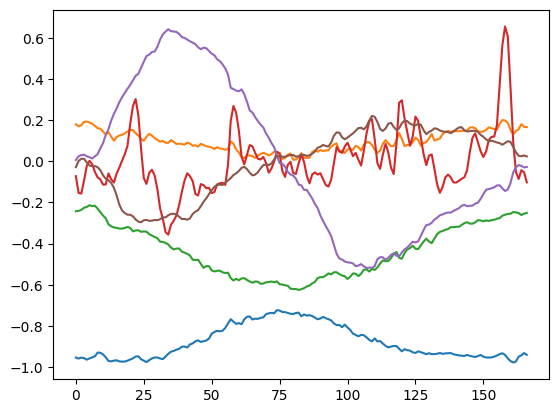

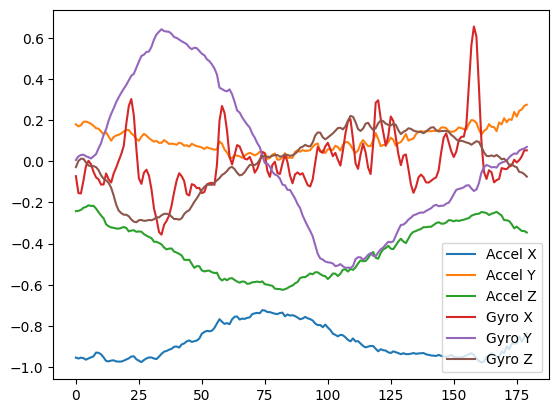

In [129]:
# Generate noise that follows the initial data pattern
imu_noise_segment = generate_patterned_imu_noise(
    noise,
    noise_type="directional_shift",
    range_percentage=0.5, # rest position
    # fluctuation_multiplier=0.05,
    # fluctuation_level=0.01,
    # peak_intensity=0.01,
    peak_probability=0
)
plt.plot(noise, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
plt.show()
# concatenate the noise with the original data
noisy_data = np.vstack([noise, imu_noise_segment])
plt.plot(noisy_data, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
plt.legend()
plt.show()

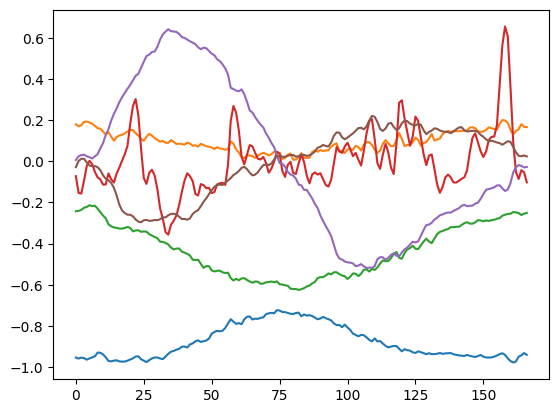

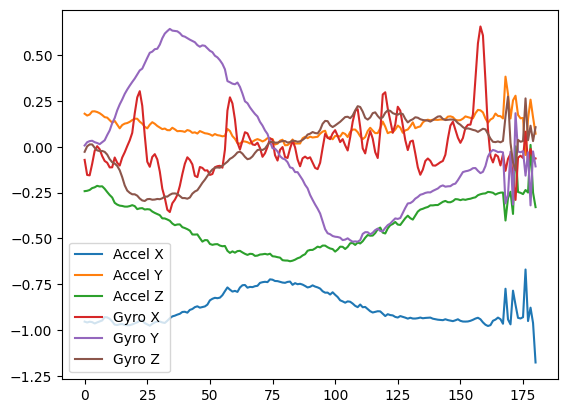

In [130]:
# Generate noise that follows the initial data pattern
imu_noise_segment = generate_patterned_imu_noise(
    noise,
    noise_type="sudden_change",
    range_percentage=0.5, # rest position
    peak_probability=.5,
    peak_intensity=0.3,
    # fluctuation_multiplier=0.05,
    # fluctuation_level=0.01,
    # peak_intensity=0.01,
)
plt.plot(noise, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
plt.show()
# concatenate the noise with the original data
noisy_data = np.vstack([noise, imu_noise_segment])
plt.plot(noisy_data, label=["Accel X", "Accel Y", "Accel Z", "Gyro X", "Gyro Y", "Gyro Z"])
plt.legend()
plt.show()